<a href="https://colab.research.google.com/github/GVSLALITHA/Projects/blob/main/TunedModel_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Fish Classification -A multiclass classification problem

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
pip install -q -U keras-tuner


Note: you may need to restart the kernel to use updated packages.


### Importing necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,

                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory('FishDataset/train',
                                                target_size=(128, 128),
                                               batch_size=32,
                                                class_mode='categorical')

test_data = test_datagen.flow_from_directory('FishDataset/test',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical', shuffle =False)

val_data = test_datagen.flow_from_directory('FishDataset/val',
                                             target_size=(128, 128),
                                             batch_size=32,
                                             class_mode='categorical', shuffle=False)

Found 6225 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.


### Plot loss and accuracy curves for the model

In [ ]:
def plot_loss_accuracy(Model):
    import matplotlib.pyplot as plt

    plt.plot(Model.history['loss'], label='train loss')
    plt.plot(Model.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

# accuracies
    plt.plot(Model.history['accuracy'], label='train acc')
    plt.plot(Model.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

In [ ]:
def generate_predictions(test_generator, ML_Model):
    yp = []

    for i in range(len(test_data)):

        x_batch, y_batch = next(test_data)
        y_test = test_generator.classes

        predicted_batch = ML_Model.predict(x_batch)

        yp.extend(np.argmax(predicted_batch, axis=1))

    return yp, y_test


In [ ]:
def get_classes(path):
    import glob
    import os
    dirs = [name for name in glob.glob(path +'*') if os.path.isdir(name)]
    class_name =[]
    for directory in dirs:
        name = str(directory)

        class_name.append(name.split("\\")[1])
    return class_name

In [ ]:
path = "FishDataset/Train/"

In [ ]:
class_labels = get_classes(path )

In [ ]:
class_labels

['animal fish',
 'animal fish bass',
 'fish sea_food black_sea_sprat',
 'fish sea_food gilt_head_bream',
 'fish sea_food hourse_mackerel',
 'fish sea_food red_mullet',
 'fish sea_food red_sea_bream',
 'fish sea_food sea_bass',
 'fish sea_food shrimp',
 'fish sea_food striped_red_mullet',
 'fish sea_food trout']

In [ ]:
def print_confusion_Matrix(classes,Y_test, Y_p, model_name):
    from sklearn.metrics import confusion_matrix, classification_report

    conf_matrix = confusion_matrix(Y_test, Y_p)
    class_names = classes
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(20, 20))
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted class', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 15)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Actual class', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 15)
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix: ' + model_name, fontsize=20)


    #plt.savefig('ConMat24.png')
    plt.show()
    print("CLASSIFICATION REPORT")
    print(".....................")
    print(classification_report(Y_test, Y_p, target_names = class_names))


### VGG16 model with tuning

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

In [ ]:
IMAGE_SIZE =[128, 128]

In [ ]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input
    from keras.preprocessing import image
    from keras.layers import Input, Lambda, Dense, Flatten
    from keras.models import Model

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(1072, activation='relu')(top_model)
    #top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
BATCH_SIZE=32
input_shape = (128, 128, 3)

n_classes=11

n_steps = train_data.samples // BATCH_SIZE
n_val_steps = val_data.samples // BATCH_SIZE
n_epochs = 45

In [ ]:
# Reset our image data generators
train_data.reset()
test_data.reset()
val_data.reset()

optim = Adam(learning_rate=0.002)

# Re-compile the model, this t ime leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim, fine_tune=2)

C:\Users\Prakash\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:

plot_loss_2 = PlotLossesCallback()

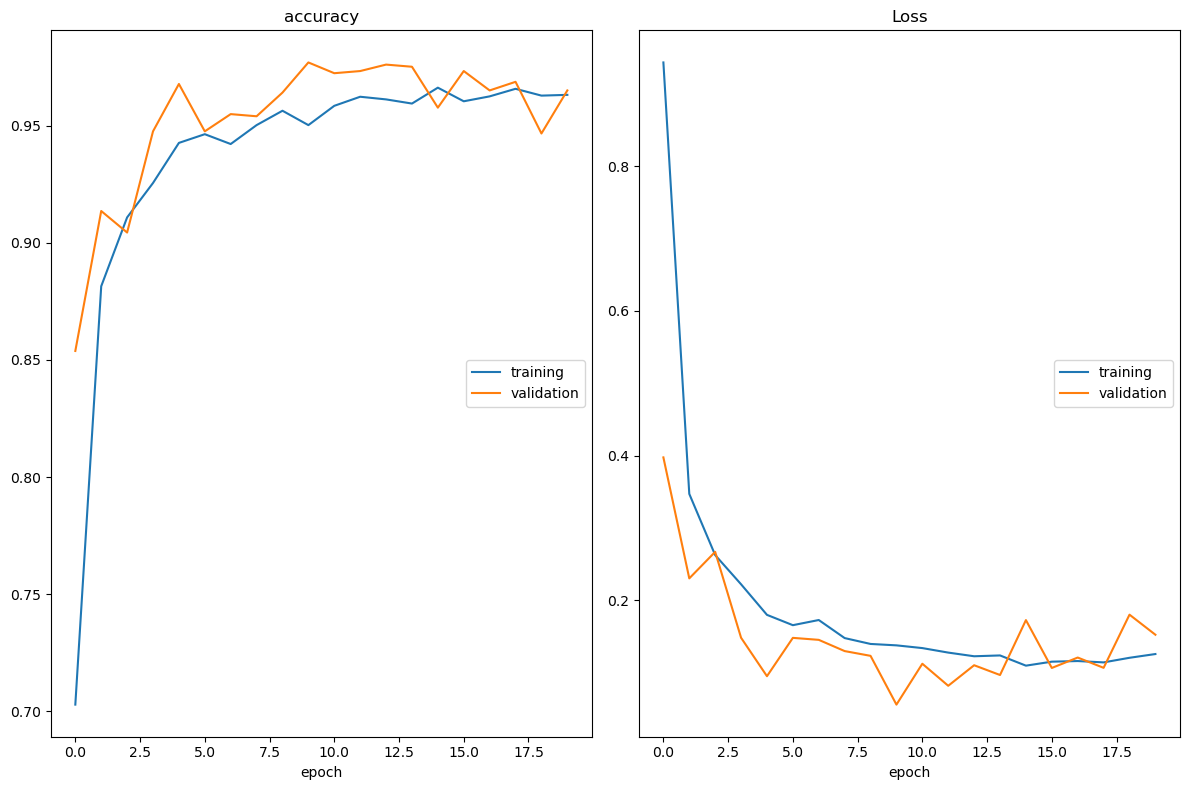

accuracy
	training         	 (min:    0.703, max:    0.966, cur:    0.963)
	validation       	 (min:    0.854, max:    0.977, cur:    0.965)
Loss
	training         	 (min:    0.109, max:    0.944, cur:    0.125)
	validation       	 (min:    0.056, max:    0.397, cur:    0.152)
194/194 [==============================] - 286s 1s/step - loss: 0.1255 - accuracy: 0.9632 - val_loss: 0.1522 - val_accuracy: 0.9651


In [ ]:
vgg_history = vgg_model_ft.fit(train_data,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=val_data,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                            verbose=1)

In [ ]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.h5') # initialize the best trained weights

true_classes = test_data.classes
class_indices = train_data.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model_ft.predict(test_data)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

100/100 [==============================] - 124s 1s/step


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 97.62%


In [ ]:
yp, ytest =generate_predictions(test_data, vgg_model_ft)

1/1 [==============================] - 1s 789ms/step


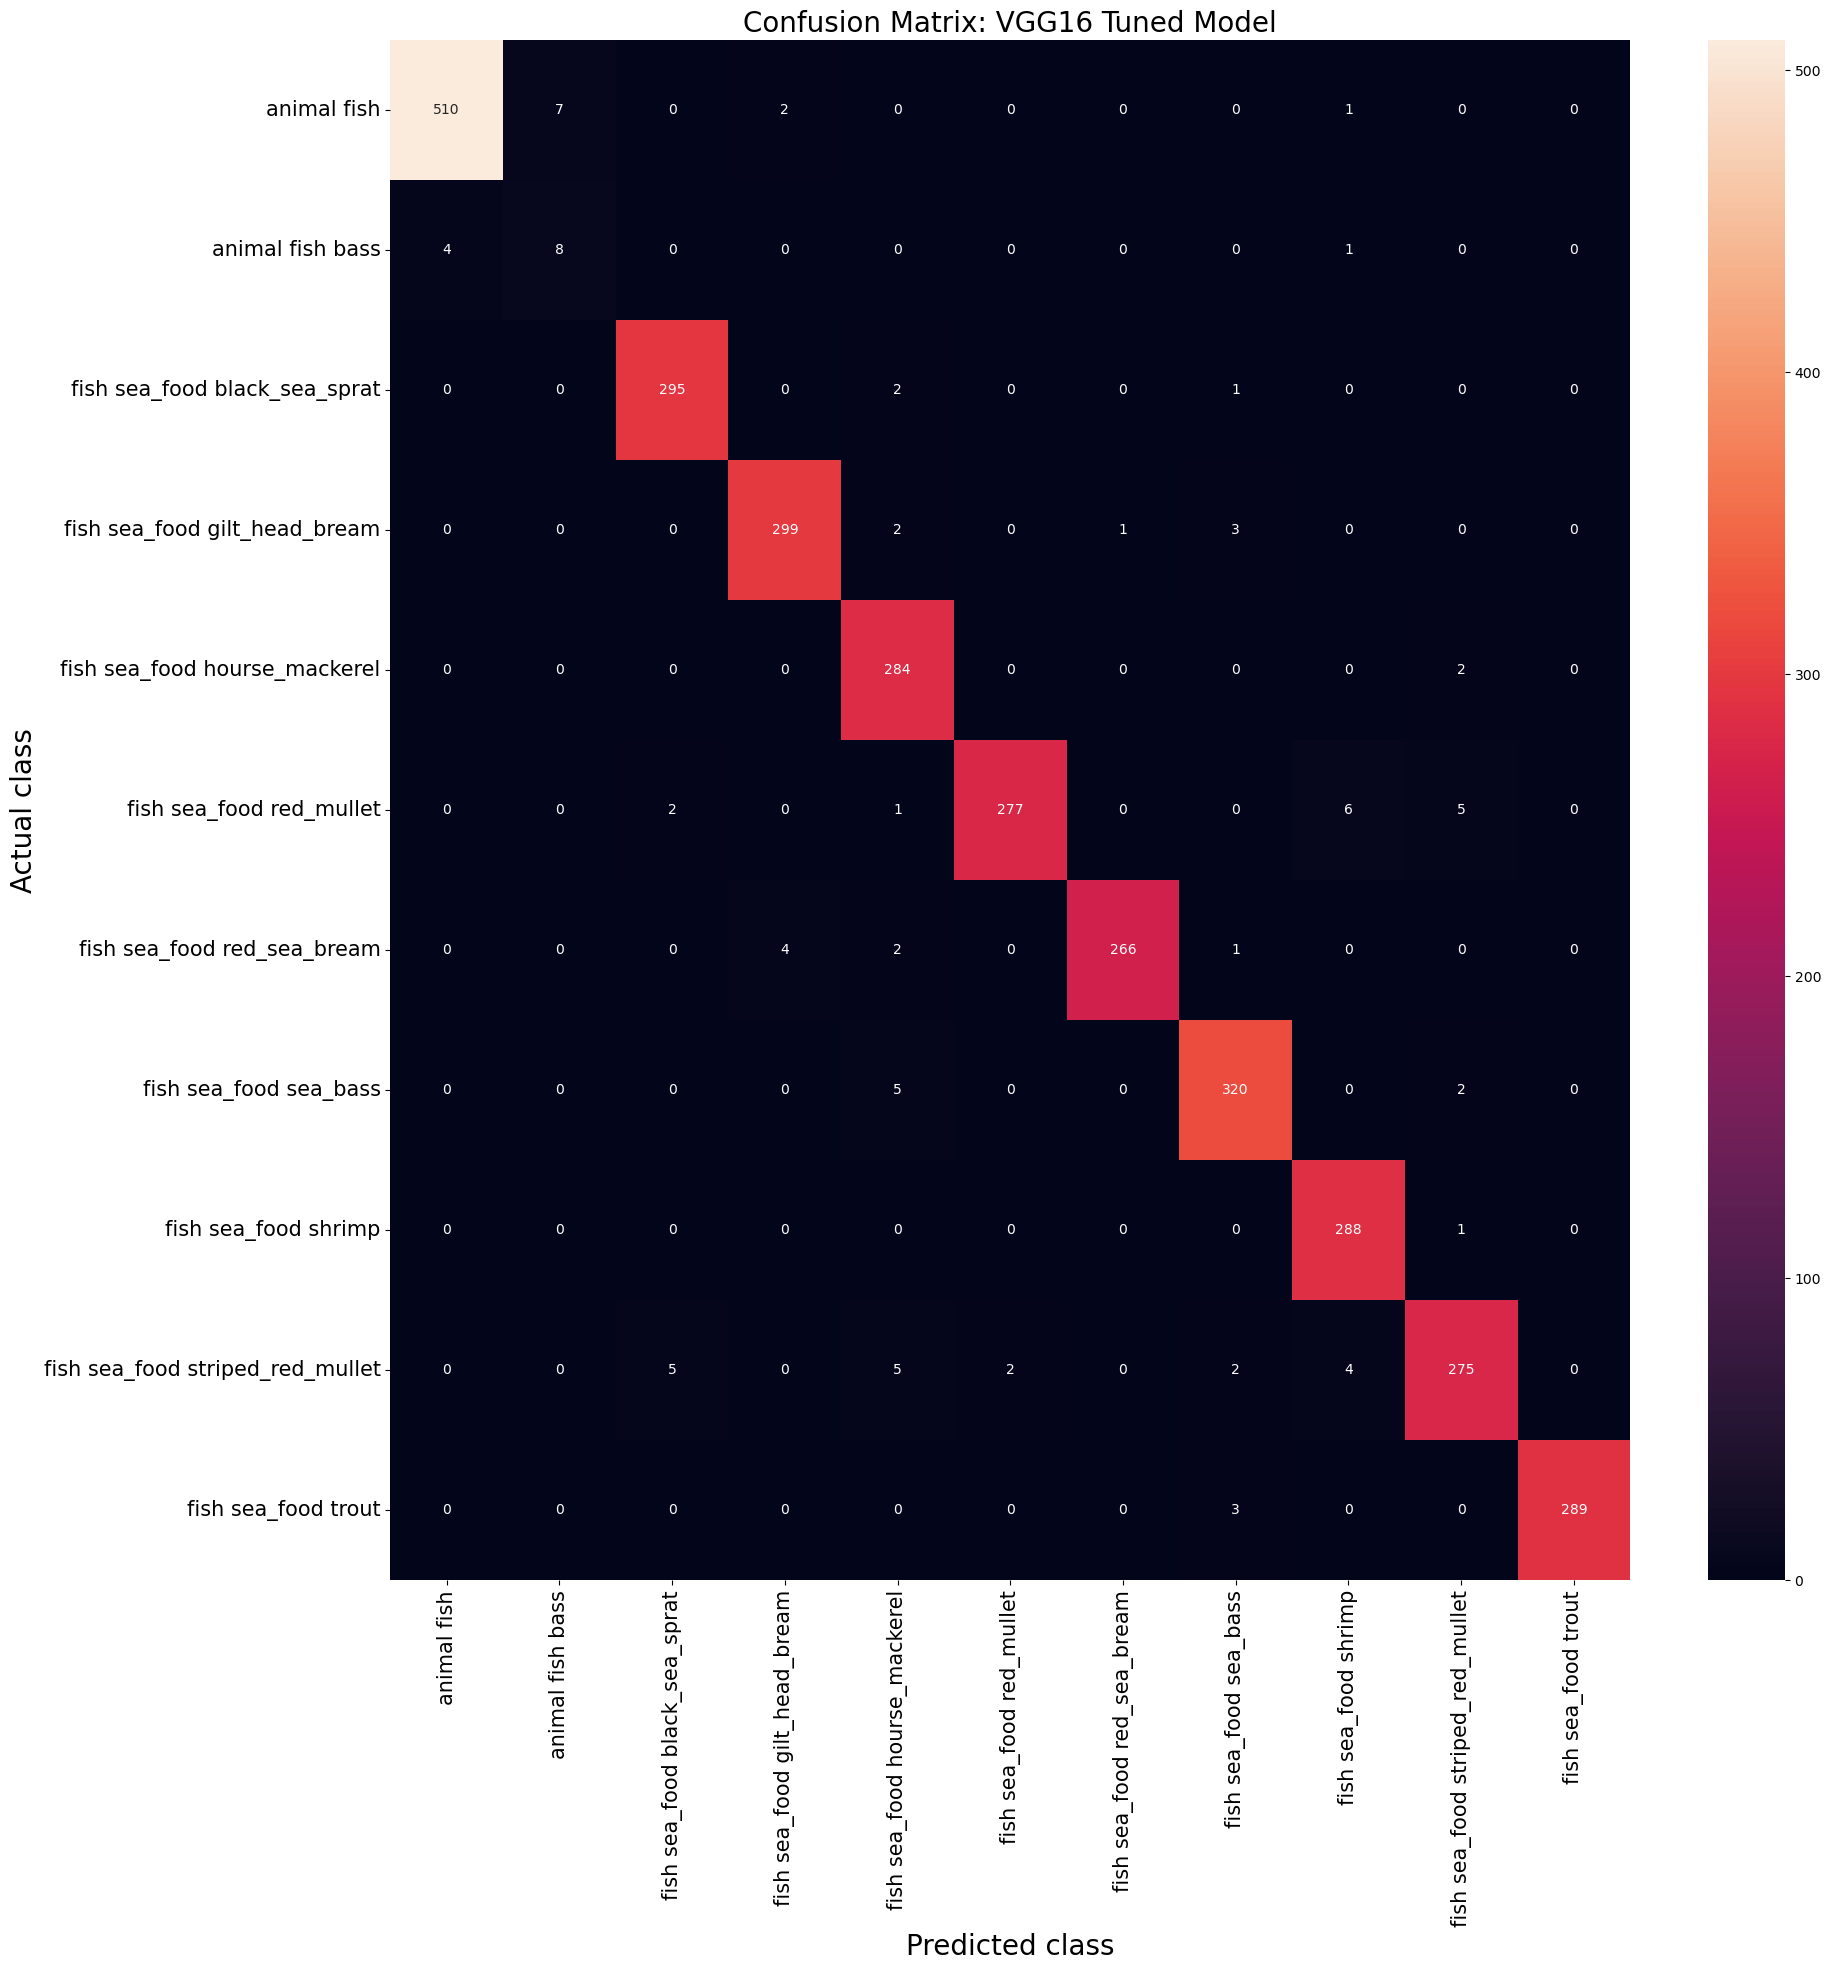

CLASSIFICATION REPORT
.....................
                                  precision    recall  f1-score   support

                     animal fish       0.99      0.98      0.99       520
                animal fish bass       0.53      0.62      0.57        13
   fish sea_food black_sea_sprat       0.98      0.99      0.98       298
   fish sea_food gilt_head_bream       0.98      0.98      0.98       305
   fish sea_food hourse_mackerel       0.94      0.99      0.97       286
        fish sea_food red_mullet       0.99      0.95      0.97       291
     fish sea_food red_sea_bream       1.00      0.97      0.99       273
          fish sea_food sea_bass       0.97      0.98      0.97       327
            fish sea_food shrimp       0.96      1.00      0.98       289
fish sea_food striped_red_mullet       0.96      0.94      0.95       293
             fish sea_food trout       1.00      0.99      0.99       292

                        accuracy                           0.98   

In [ ]:
print_confusion_Matrix(class_labels, ytest, yp, 'VGG16 Tuned Model')

* Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. In this tutorial, you use the Hyperband tuner.

* To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

### Load the image for which prediction to be made

In [ ]:
img_path='FishDataset/test/fish sea_food red_mullet/2S8JUO80K7YB.jpg'

### Define a function to make prediction on new image using saved model

In [ ]:

def make_prediction(path, class_names, dl_model):
    """


    """
    from keras_preprocessing.image import load_img, img_to_array
    img=load_img(path,target_size=(128, 128,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=dl_model.predict(img)
    print(answer)
    y_class = answer.argmax(axis=-1)

    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = class_names[y]
    print("Acctual image is:")
    pic=load_img(path,target_size=(128,128,3))
    plt.imshow(pic)

    return "predicted class: " + res

### Load the saved model (.h5)

In [ ]:

from keras.models import load_model


1/1 [==============================] - 0s 126ms/step
[[1.3076634e-09 6.3408324e-12 3.5769226e-05 2.8627127e-08 1.5431571e-05
  9.9724650e-01 8.3865871e-07 3.4224587e-07 4.4230617e-08 2.7010022e-03
  6.2079715e-09]]
Acctual image is:


'predicted class: fish sea_food red_mullet'

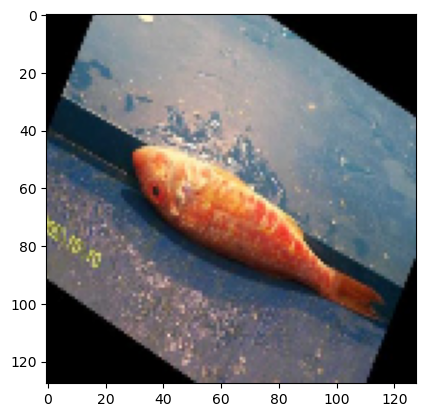

In [ ]:
vgg_saved_model = load_model('./tl_model_v1.weights.best.h5')
make_prediction(img_path, class_labels, vgg_saved_model)